<a href="https://colab.research.google.com/github/InsightMart/DSPL_project/blob/main/Model_Nethmi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
import joblib  # For saving the model


In [ ]:
df = pd.read_csv('/content/cleaned_train_data.csv')

In [ ]:
df.head()

,Customer_ID,outlet_city,luxury_sales,fresh_sales,dry_sales,cluster_catgeory,Encoded_outlet_city
0,10493832.0,Kelaniya,1209.60,756.00,5292.00,4,11
1,10178643.0,Moratuwa,1590.12,1060.08,6007.12,1,13
2,10513916.0,Wattala,2288.88,1481.04,9155.52,4,19
3,10334589.0,Wattala,2274.94,1739.66,9099.76,4,19
4,10458365.0,Kelaniya,2345.49,2069.55,9243.99,4,11


In [ ]:
df.describe()

,Customer_ID,luxury_sales,fresh_sales,dry_sales,cluster_catgeory,Encoded_outlet_city
count,7.741480e+05,774150.000000,774150.000000,774150.000000,774150.000000,774150.000000
mean,1.038708e+07,1921.959149,4428.623964,4676.244392,3.292101,9.382051
std,2.234797e+05,1004.058439,3334.579088,3409.311590,1.867015,5.778111
min,1.000000e+07,500.000000,500.000000,500.000000,1.000000,0.000000
25%,1.019354e+07,1213.552500,1620.220000,1788.000000,2.000000,4.000000
50%,1.038708e+07,1715.280000,3356.510000,3727.760000,3.000000,9.000000
75%,1.058062e+07,2338.680000,6671.280000,7161.760000,5.000000,14.000000
max,1.077415e+07,6999.650000,13997.900000,13999.300000,6.000000,19.000000


In [ ]:
df.shape

(774150, 7)

In [ ]:
# Drop only for training
X = df.drop(columns=['Customer_ID', 'cluster_catgeory','outlet_city'])  # Features
y = df['cluster_catgeory']  # Target


In [ ]:
#Scale numerical features
scaler = StandardScaler()
X1 = scaler.fit_transform(X)

In [ ]:
# Train-Test Split
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=0.3, random_state=42,stratify = y)

In [ ]:
print(X1_train.shape)
print(X1_test.shape)
print(y_train.shape)
print(y_test.shape)

(541905, 4)
(232245, 4)
(541905,)
(232245,)


In [ ]:
# Train Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X1_train, y_train)


RandomForestClassifier(random_state=42)

In [ ]:
# Make Predictions
y_pred = rf_model.predict(X1_test)

In [ ]:
compare_results_rf_df = pd.DataFrame({'Actual':y_test, 'Predicted': y_pred})
compare_results_rf_df.to_csv('rf_pred_comparison.csv', index=True)
compare_results_rf_df


,Actual,Predicted
201122,2,2
207061,2,2
375630,1,1
552084,1,1
24499,4,4
...,...,...
253842,2,2
615954,6,6
338522,5,5
710046,6,6


In [ ]:
# Evaluate Model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9992


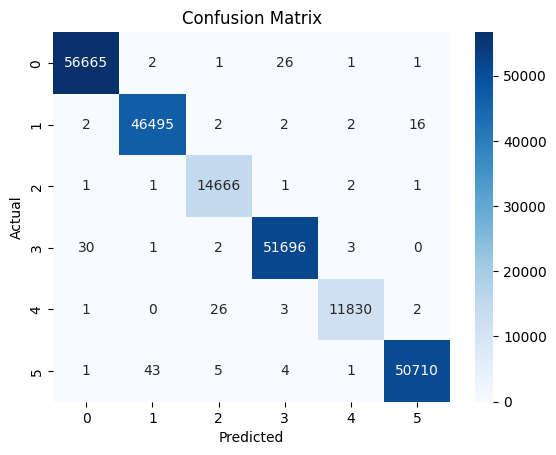

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00     56696
           2       1.00      1.00      1.00     46519
           3       1.00      1.00      1.00     14672
           4       1.00      1.00      1.00     51732
           5       1.00      1.00      1.00     11862
           6       1.00      1.00      1.00     50764

    accuracy                           1.00    232245
   macro avg       1.00      1.00      1.00    232245
weighted avg       1.00      1.00      1.00    232245



In [ ]:
# Step 9: Multi-Class ROC Curve
# Binarize the output
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]


In [ ]:
# Train One-vs-Rest (OvR) classifier with fewer trees
ovr_clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=10, random_state=14, max_depth=10))
ovr_clf.fit(X1_train, y_train)


OneVsRestClassifier(estimator=RandomForestClassifier(max_depth=10,
                                                     n_estimators=10,
                                                     random_state=14))

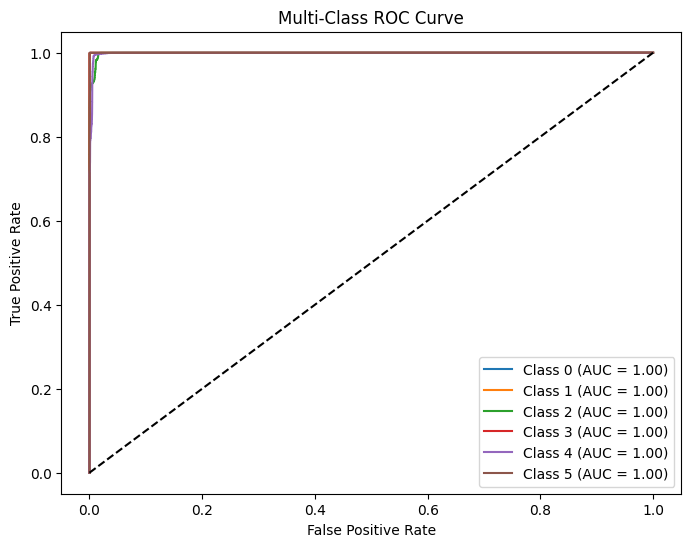

In [ ]:
# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    # Get predicted probabilities for the current class
    y_score = ovr_clf.predict_proba(X1_test)[:, i]
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Hyperparameter Tuning with GridSearchCV
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

In [ ]:
#grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring="accuracy", n_jobs=-1)
#grid_search.fit(X1_train, y_train)

In [ ]:
# Best parameters and accuracy
#print("Best Parameters:", grid_search.best_params_)
#print("Best Accuracy:", grid_search.best_score_)

In [ ]:
# Use best model
#rf_model = grid_search.best_estimator_

In [ ]:
# Save the Final Model
#joblib.dump(rf_model, "random_forest_model.pkl")
#joblib.dump(scaler, "scaler.pkl")  # Save scaler for future use

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
}

# Perform Grid Search
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found:", grid_search.best_params_)

# Train final model with best parameters
best_rf = grid_search.best_estimator_
